<a href="https://colab.research.google.com/github/CSC345DSLoveYou/HousePrice_DSLoveyou/blob/master/HousePrices_DSLoveYou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# If you want to save the file, this ipynb file will save on the **CSC345-DS-Project shared drive** when you write the code that here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
pip install --upgrade pingouin

     |████████████████████████████████| 225kB 4.6MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-cp36-none-any.whl size=221688 sha256=9719a558a2e0d4804b5d1d8b55f71bbc97f70cf0a2de66f814eaec8b2bf7dd2c
  Stored in directory: /root/.cache/pip/wheels/d6/9e/53/f885f73f29cf7c8cac3d8f4b1532bbfef2f5eb543946ac9055
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4961 sha256=e7baa0077f131ebef0eb3af30ce8e71be6f03149fbe0b0dd28435d6f45a11ab4
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7051 sha256=7c9c45c978bc19c19dc594da8030cc71005d9fe22e103a6e91ffad9557e05fc5
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


In [3]:
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(pd.__version__)

1.0.5


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dfTrain = pd.read_csv("/content/drive/Shared drives/CSC345-DS-Project/house-prices-advanced-regression-techniques/train.csv"
        , sep = ",")
print('%i subjects and %i columns' % dfTrain.shape)
dfTrain.head()


1460 subjects and 81 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
dfTest = pd.read_csv("/content/drive/Shared drives/CSC345-DS-Project/house-prices-advanced-regression-techniques/test.csv"
        , sep = ",")
print('%i subjects and %i columns' % dfTest.shape)

dfTest.head()

1459 subjects and 80 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
dfSample = pd.read_csv("/content/drive/Shared drives/CSC345-DS-Project/house-prices-advanced-regression-techniques/sample_submission.csv"
        , sep = ",")
print('%i subjects and %i columns' % dfSample.shape)

dfSample.head()

1459 subjects and 2 columns


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [9]:
#The relation of YearBuilt and GarageArea 1
import pingouin as pg
pg.corr(x=dfTrain['YearBuilt'], y=dfTrain['GarageArea'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,1460,0.478954,"[0.44, 0.52]",0.229397,0.228339,1.375227e-84,8.003e+80,1.0


In [10]:
#The relation of OverallQual and SalePrice 2
import pingouin as pg
pg.corr(x=dfTrain['OverallQual'], y=dfTrain['SalePrice'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,1460,0.790982,"[0.77, 0.81]",0.625652,0.625138,2.185675e-313,inf,1.0


In [11]:
#The relation of GrLivArea and SalePrice 3
import pingouin as pg
pg.corr(x=dfTrain['GrLivArea'], y=dfTrain['SalePrice'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,1460,0.708624,"[0.68, 0.73]",0.502149,0.501465,4.518034e-223,1.066e+219,1.0


In [12]:
import plotly.express as px
fig = px.scatter(dfTrain, x="YearBuilt", y="GarageArea")
fig.show()

#1

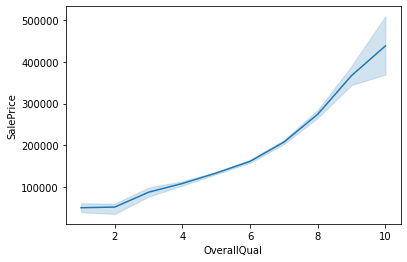

In [13]:
data = pd.concat([dfTrain['SalePrice'], dfTrain['OverallQual'],dfTrain['MSSubClass']], axis=1)
sns.lineplot(x = "OverallQual", y = "SalePrice",data=data,palette="viridis")
plt.show()
#2

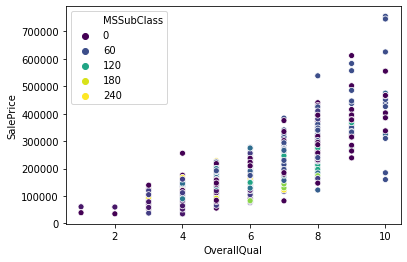

In [14]:
data = pd.concat([dfTrain['SalePrice'], dfTrain['OverallQual'],dfTrain['MSSubClass']], axis=1)
sns.scatterplot(x = "OverallQual", y = "SalePrice",data=data, hue= 'MSSubClass',palette="viridis")
plt.show()

#2

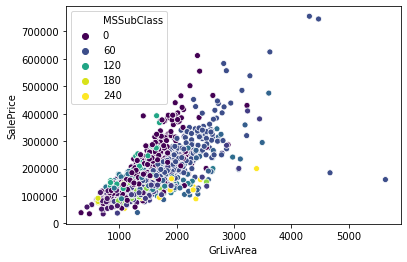

In [15]:
data = pd.concat([dfTrain['GrLivArea'], dfTrain['SalePrice'],dfTrain['MSSubClass']], axis=1)
sns.scatterplot(x = "GrLivArea", y = "SalePrice",data=data, hue= 'MSSubClass',palette="viridis")
plt.show()
#3

In [16]:
import plotly.express as px
fig = px.histogram(dfTrain, x="YrSold")
fig.show()

In [17]:
import plotly.express as px
fig = px.bar(dfTrain, x="MSSubClass", y="SalePrice")
fig.show()


In [18]:
dfTrain.corr().round(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.00,0.01,-0.01,-0.03,-0.03,0.01,-0.01,-0.02,-0.05,-0.01,-0.01,-0.01,-0.02,0.01,0.01,-0.04,0.01,0.00,-0.02,0.01,0.01,0.04,0.00,0.03,-0.02,0.00,0.02,0.02,-0.03,-0.00,0.00,-0.05,0.00,0.06,-0.01,0.02,0.00,-0.02
MSSubClass,0.01,1.00,-0.39,-0.14,0.03,-0.06,0.03,0.04,0.02,-0.07,-0.07,-0.14,-0.24,-0.25,0.31,0.05,0.07,0.00,-0.00,0.13,0.18,-0.02,0.28,0.04,-0.05,0.09,-0.04,-0.10,-0.01,-0.01,-0.01,-0.04,-0.03,0.01,-0.01,-0.01,-0.02,-0.08
LotFrontage,-0.01,-0.39,1.00,0.43,0.25,-0.06,0.12,0.09,0.19,0.23,0.05,0.13,0.39,0.46,0.08,0.04,0.40,0.10,-0.01,0.20,0.05,0.26,-0.01,0.35,0.27,0.07,0.29,0.34,0.09,0.15,0.01,0.07,0.04,0.21,0.00,0.01,0.01,0.35
LotArea,-0.03,-0.14,0.43,1.00,0.11,-0.01,0.01,0.01,0.10,0.21,0.11,-0.00,0.26,0.30,0.05,0.00,0.26,0.16,0.05,0.13,0.01,0.12,-0.02,0.19,0.27,-0.02,0.15,0.18,0.17,0.08,-0.02,0.02,0.04,0.08,0.04,0.00,-0.01,0.26
OverallQual,-0.03,0.03,0.25,0.11,1.00,-0.09,0.57,0.55,0.41,0.24,-0.06,0.31,0.54,0.48,0.30,-0.03,0.59,0.11,-0.04,0.55,0.27,0.10,-0.18,0.43,0.40,0.55,0.60,0.56,0.24,0.31,-0.11,0.03,0.06,0.07,-0.03,0.07,-0.03,0.79
OverallCond,0.01,-0.06,-0.06,-0.01,-0.09,1.00,-0.38,0.07,-0.13,-0.05,0.04,-0.14,-0.17,-0.14,0.03,0.03,-0.08,-0.05,0.12,-0.19,-0.06,0.01,-0.09,-0.06,-0.02,-0.32,-0.19,-0.15,-0.00,-0.03,0.07,0.03,0.05,-0.00,0.07,-0.00,0.04,-0.08
YearBuilt,-0.01,0.03,0.12,0.01,0.57,-0.38,1.00,0.59,0.32,0.25,-0.05,0.15,0.39,0.28,0.01,-0.18,0.20,0.19,-0.04,0.47,0.24,-0.07,-0.17,0.10,0.15,0.83,0.54,0.48,0.22,0.19,-0.39,0.03,-0.05,0.00,-0.03,0.01,-0.01,0.52
YearRemodAdd,-0.02,0.04,0.09,0.01,0.55,0.07,0.59,1.00,0.18,0.13,-0.07,0.18,0.29,0.24,0.14,-0.06,0.29,0.12,-0.01,0.44,0.18,-0.04,-0.15,0.19,0.11,0.64,0.42,0.37,0.21,0.23,-0.19,0.05,-0.04,0.01,-0.01,0.02,0.04,0.51
MasVnrArea,-0.05,0.02,0.19,0.10,0.41,-0.13,0.32,0.18,1.00,0.26,-0.07,0.11,0.36,0.34,0.17,-0.07,0.39,0.09,0.03,0.28,0.20,0.10,-0.04,0.28,0.25,0.25,0.36,0.37,0.16,0.13,-0.11,0.02,0.06,0.01,-0.03,-0.01,-0.01,0.48
BsmtFinSF1,-0.01,-0.07,0.23,0.21,0.24,-0.05,0.25,0.13,0.26,1.00,-0.05,-0.50,0.52,0.45,-0.14,-0.06,0.21,0.65,0.07,0.06,0.00,-0.11,-0.08,0.04,0.26,0.15,0.22,0.30,0.20,0.11,-0.10,0.03,0.06,0.14,0.00,-0.02,0.01,0.39


Text(0.5, 1.0, 'Correlation matrix')

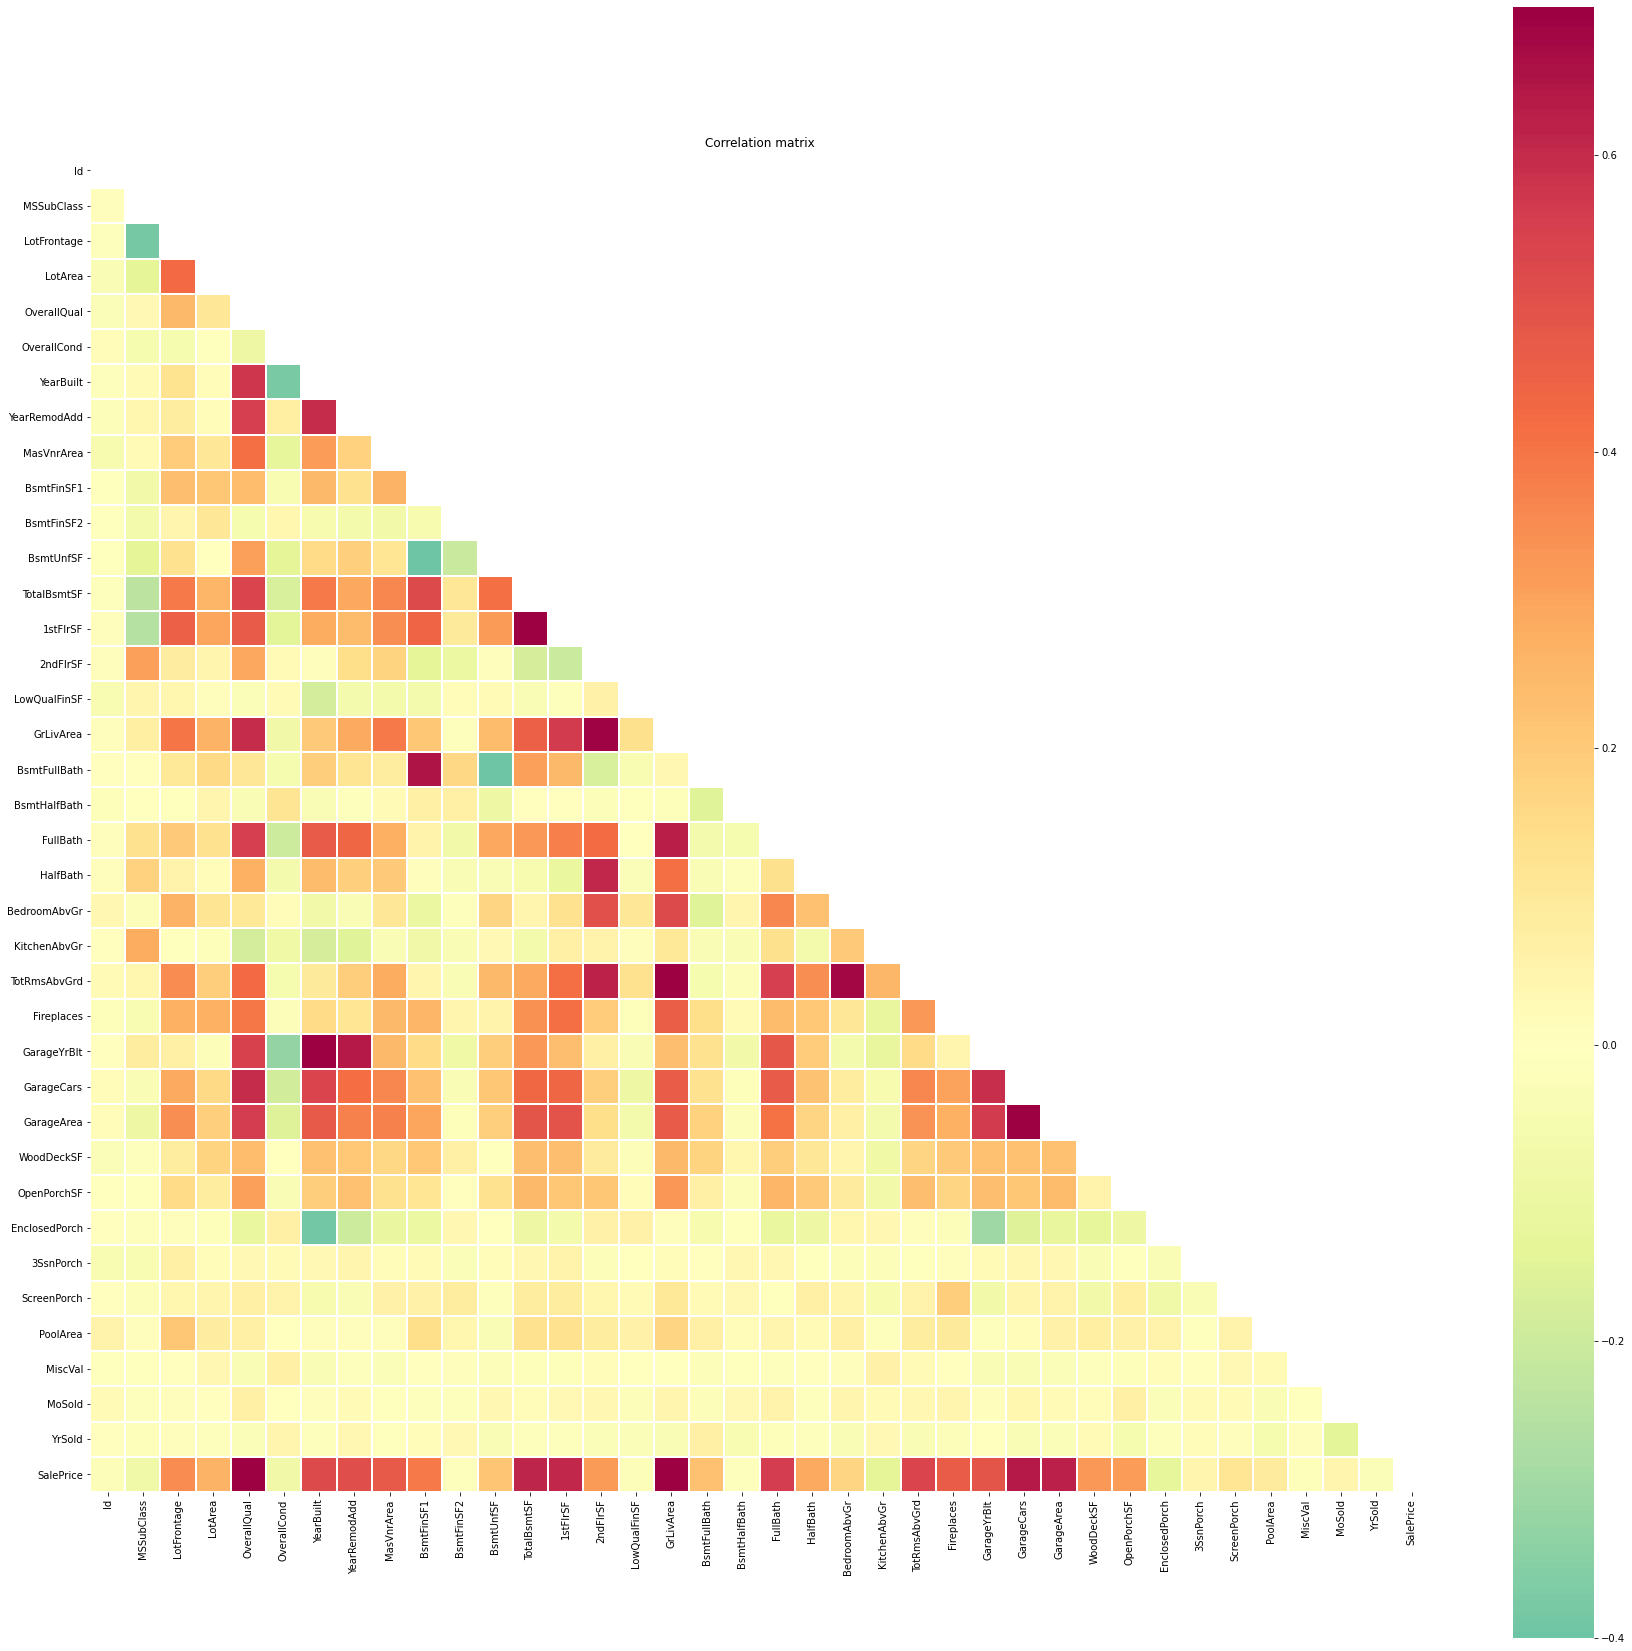

In [19]:
corrs = dfTrain.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(30,30))
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.4, vmax=.7, linewidths=1,center= 0)
plt.title('Correlation matrix')